### Overview

The Basic Idea behind this model is to train different models for different porposes. As Neural Networks are black box models; It is hard to define a method that it can follow.
As the data is highly imbalanced and the number of categories is large.</br>
We wanted to create a less biased model which still has a considerably large training sample.</br>
As the WIESP dataset follow the "B-" and "I-" convention from the IOB2 syntax.</br>
We wanted to see if the model can predict better once we predict which tags are in the B-, I- and O category.</br>
We will be creating categories and then sub categories.</br>


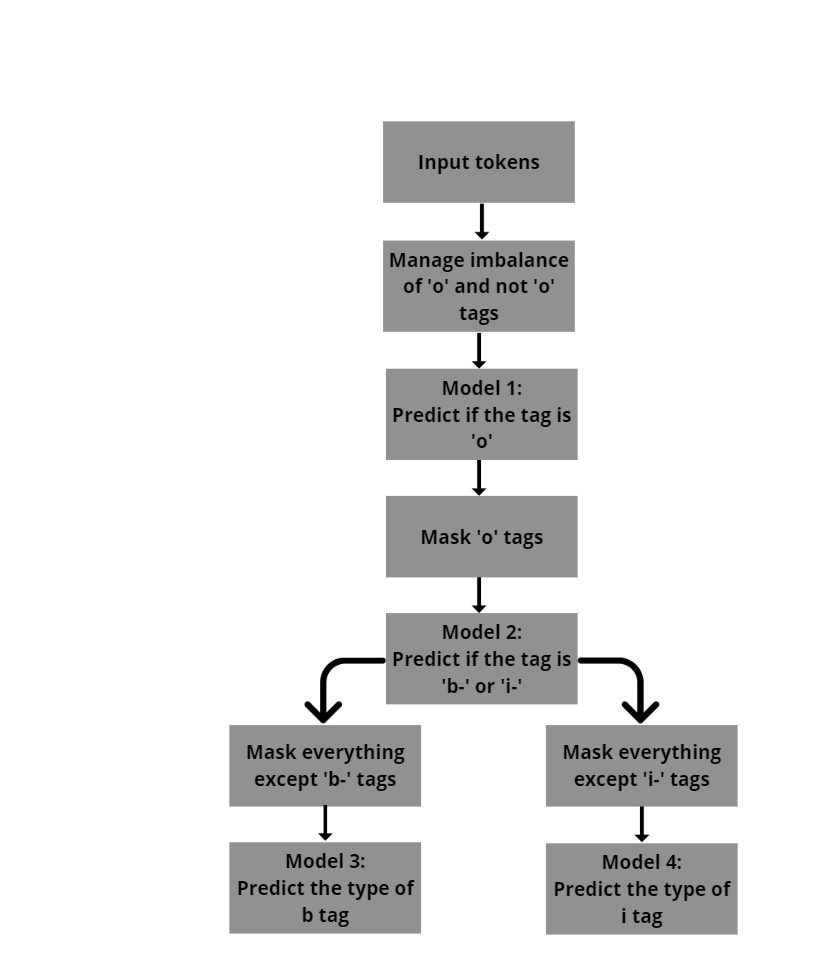

We have created the model as shown above. We have preprocessed the input and output as need for the purpose it serves. Initailly, we were hoping that this model would give us atleast a less biased model.</br>
We have used the same elmo model architecture, as it was performing well, as compared to other architectures.</br>
Reference for the elmo model architecture: https://medium.com/analytics-vidhya/named-entity-recognition-using-deep-learning-elmo-embedding-bi-lstm-48295bc66cab

### Preprocessing

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import statistics as st
import tensorflow as tf
from math import ceil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

%matplotlib inline

In [ ]:
# Importing data from drive
data = pd.read_json('/content/drive/MyDrive/AI-3/Project/fgrezes:WIESP2022-NER/WIESP2022-NER-TRAINING.jsonl', lines=True)
tags = pd.read_json('/content/drive/MyDrive/AI-3/fgrezes:WIESP2022-NER/ner_tags.json', lines=True)
tags = tags.T.reset_index()

In [ ]:
# Having a look at the distribution of B-I-O
print("""
B tags:""")
print(tags['index'].loc[:30])
print("""
I tags:""")
print(tags['index'].loc[31:61])
print("""
O tags:""")
print(tags['index'].loc[62])


B tags:
0                     B-Archive
1             B-CelestialObject
2       B-CelestialObjectRegion
3             B-CelestialRegion
4                    B-Citation
5               B-Collaboration
6           B-ComputingFacility
7                    B-Database
8                     B-Dataset
9      B-EntityOfFutureInterest
10                      B-Event
11                 B-Fellowship
12                    B-Formula
13                      B-Grant
14                 B-Identifier
15                 B-Instrument
16                   B-Location
17                    B-Mission
18                      B-Model
19    B-ObservationalTechniques
20                B-Observatory
21               B-Organization
22                     B-Person
23                   B-Proposal
24                   B-Software
25                     B-Survey
26                        B-Tag
27                  B-Telescope
28                B-TextGarbage
29                        B-URL
30                 B-Wavelength

In [ ]:
# Performing train test split
train_data, test_data = train_test_split(data, train_size=0.8, random_state=1)

In [ ]:
# creating a reference_dataset and predictions_dataset for later use
reference_data = test_data[['unique_id','ner_tags']]
predictions_dataset = test_data[['unique_id']]

In [ ]:
# creating a column called unit number
train_data['Unit #'] = train_data.index

#We set the index as the unit number. Then we filter each unit, joininig the text
train_data.set_index('Unit #', inplace=True)

In [ ]:
# creating a column called unit number for test data
test_data['Unit #'] = test_data.index
reference_data['Unit #'] = reference_data.index

# We set the index as the unit number. Then we filter each unit, joininig the text
test_data.set_index('Unit #', inplace=True)
reference_data.set_index('Unit #', inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Exploding ner_ids and tokens
train_data = train_data.explode(['ner_ids','tokens','ner_tags'])
test_data = test_data.explode(['ner_ids','tokens','ner_tags'])

In [ ]:
# Since the ner_ids also have the value 0, this can be confusing when we use padding 0.
train_data.ner_ids = train_data.ner_ids.values + 1
test_data.ner_ids = test_data.ner_ids.values + 1

In [ ]:
# One hot encoding if a token belongs to b, i or o
b_i_o = []
for i in train_data['ner_ids']:
  if i == 63:
    b_i_o.append([0,0,1])
  if i >= 1 and i < 32:
    b_i_o.append([1,0,0])
  if i >= 32 and i < 63:
    b_i_o.append([0,1,0])

train_data[['b','i','o']] = b_i_o

In [ ]:
b_i_o = []
for i in test_data['ner_ids']:
  if i == 63:
    b_i_o.append([0,0,1])
  if i >= 1 and i < 32:
    b_i_o.append([1,0,0])
  if i >= 32 and i < 63:
    b_i_o.append([0,1,0])

test_data[['b','i','o']] = b_i_o

We have not taken out special characters as we understand for tags like urls and formulas, it is necessary for the text to have special characters.

In [ ]:
# Tokenize the words
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None,
                                                filters='',
                                                lower=True,
                                                split=' ') # Initialize

tokenizer.fit_on_texts(train_data.tokens.values) # Fit on training data

In [ ]:
# Transform to numeric
tokens_train = tokenizer.texts_to_sequences(train_data.tokens.values)
tokens_test = tokenizer.texts_to_sequences(test_data.tokens.values)

In [ ]:
# Have a look at the data to ensure that there are no empty elements
print("The number of empty lists in train data : ",np.array([token==[] for token in tokens_train]).sum())
print("The number of empty lists in test data : ",np.array([token==[] for token in tokens_test]).sum())

The number of empty lists in train data :  0
The number of empty lists in test data :  7582


In [ ]:
# Remove empty elements
b = np.array([token!=[] for token in tokens_test])
test_data = test_data.iloc[b,:]
tokens_test = np.array(tokens_test)[b]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [ ]:
# creating a column called tokens.
train_data.tokens = tokens_train
test_data.tokens = tokens_test

train_data.tokens=train_data.tokens.map(lambda x: x[0])
test_data.tokens=test_data.tokens.map(lambda x: x[0])

In [ ]:
# We have kept the size of one unit to be simply 50.
# as this text is not broken down by sentences, it has long length this may lead to vanishing gradients later.
si = 50
IDs_train = train_data.index.unique()
train_sentences = []
train_tags = []
train_Ns = []
train_os = []
train_bs = []
train_is = []

 # For each id
for i in IDs_train:
    # We extract the respective data
    sel = train_data.loc[i]
    # A sentence is a list of tokens
    sentence = sel.tokens.values
    # The tags correspond to each token
    tag = sel['ner_ids'].values 
    o = sel['o']
    b = sel['b']
    i = sel['i']
    
    sen_size = sentence.shape[0]

    if sen_size>si:
      while(sen_size>si):
        # We store the sentences in a list
        train_sentences.append(np.array(sentence[:si]))
        # We do the same with the tags  
        train_tags.append(np.array(tag[:si]))            
        train_os.append(np.array(o[:si]))
        train_bs.append(np.array(b[:si]))
        train_is.append(np.array(i[:si]))
        # And store the length of the sentence
        train_Ns.append(si)
        sentence = sentence[si:]
        tag = tag[si:]
        o = o[si:]
        b = b[si:]
        i = i[si:]
        sen_size = sentence.shape[0]
      train_sentences.append(np.array(sentence))
      train_tags.append(np.array(tag))
      train_os.append(np.array(o))
      train_bs.append(np.array(b))
      train_is.append(np.array(i))
      train_Ns.append(sentence.shape[0])

    # adding the last sentence and tags
    else:
      train_sentences.append(np.array(sentence))
      train_tags.append(np.array(tag))            
      train_os.append(np.array(o[:si]))
      train_bs.append(np.array(b[:si]))
      train_is.append(np.array(i[:si]))
      train_Ns.append(sentence.shape[0])

In [ ]:
# We transform everything into np arrays    
train_Ns = np.array(train_Ns)
train_sentences = np.array(train_sentences)
train_tags = np.array(train_tags)
train_os = np.array(train_os)
train_bs = np.array(train_bs)
train_is = np.array(train_is)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

In [ ]:
# having a quick look at the shapes of the arrays created above
print(IDs_train.shape, train_Ns.shape, train_sentences.shape, train_tags.shape, train_os.shape, train_bs.shape, train_is.shape)

(1402,) (9779,) (9779,) (9779,) (9779,) (9779,) (9779,)


In [ ]:
# For simplicity, we create a padded array beforehand
train_sentences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sentences, padding='post')
train_tags_padded = tf.keras.preprocessing.sequence.pad_sequences(train_tags, padding='post')
# here we have 1 describing tags which are not o and 2 describing tags which are o. 0 represents padding
train_os_padded = tf.keras.preprocessing.sequence.pad_sequences(train_os + 1, padding='post')
train_bs_padded = tf.keras.preprocessing.sequence.pad_sequences(train_bs, padding='post')
train_is_padded = tf.keras.preprocessing.sequence.pad_sequences(train_is, padding='post')

In [ ]:
# We create the training set structure
IDs_test = test_data.index.unique()

test_sentences = []
test_tags = []
test_Ns = []
test_os = []
test_bs = []
test_is = []

# For each id
for i in IDs_test:
    # We extract the respective data
    sel = test_data.loc[i]
    # A sentence is a list of tokens
    sentence = sel.tokens.values 
    tag = sel['ner_ids'].values
    o = sel['o']
    b = sel['b']
    i = sel['i']

    sen_size = sentence.shape[0]

    if sen_size>si:
      while(sen_size>si):
        # We store the sentences in a list
        test_sentences.append(np.array(sentence[:si]))
        # We do the same with the tags  
        test_tags.append(np.array(tag[:si]))            
        test_os.append(np.array(o[:si]))
        test_bs.append(np.array(b[:si]))
        test_is.append(np.array(i[:si]))
        # And store the length of the sentence
        test_Ns.append(si)
        sentence = sentence[si:]
        tag = tag[si:]
        o = o[si:]
        b = b[si:]
        i = i[si:]
        sen_size = sentence.shape[0]
      
      # adding the last sentence and tag
      test_sentences.append(np.array(sentence))
      test_tags.append(np.array(tag))            
      test_os.append(np.array(o))
      test_bs.append(np.array(b))
      test_is.append(np.array(i))
      test_Ns.append(sentence.shape[0])

    # adding the last sentence and tags
    else:
      test_sentences.append(np.array(sentence))
      test_tags.append(np.array(tag))
      test_os.append(np.array(o[:si]))
      test_bs.append(np.array(b[:si]))
      test_is.append(np.array(i[:si]))
      test_Ns.append(sentence.shape[0])

In [ ]:
# We transform everything into np arrays    
test_Ns = np.array(test_Ns)
test_sentences = np.array(test_sentences)
test_tags = np.array(test_tags)
test_os = np.array(test_os)
test_bs = np.array(test_bs)
test_is = np.array(test_is)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

In [ ]:
# For simplicity, we create a padded array beforehand
test_sentences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sentences, padding='post')
test_tags_padded = tf.keras.preprocessing.sequence.pad_sequences(test_tags, padding='post')
# here we have 1 describing tags which are not o and 2 describing tags which are o. 0 represents padding
test_os_padded = tf.keras.preprocessing.sequence.pad_sequences(test_os + 1, padding='post')
test_bs_padded = tf.keras.preprocessing.sequence.pad_sequences(test_bs, padding='post')
test_is_padded = tf.keras.preprocessing.sequence.pad_sequences(test_is, padding='post')

In [ ]:
# having a quick look at the shapes of the arrays created above
print(IDs_test.shape, test_Ns.shape, test_sentences.shape, test_tags.shape, test_os.shape, test_bs.shape, test_is.shape)

(351,) (2399,) (2399,) (2399,) (2399,) (2399,) (2399,)


In [ ]:
# Defining vocab_size
vocab_size = len(tokenizer.word_counts)

In [ ]:
# Changing the value of tags[0] to match the NER_ids we have defined
tags[0] = tags[0].values + 1

### Manage imbalance of 'o' and not 'o' tags

The number of o tokens :  373897
The number of not o tokens :  80498
The number of padding tokens :  34555


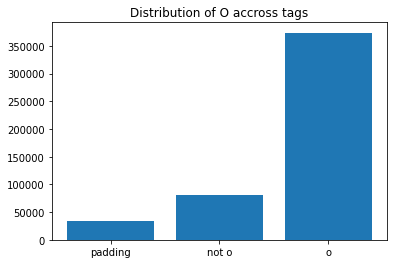

In [ ]:
# count the number of tokens which belong to the category
# Having a quick look at the distribution of the data
print("The number of o tokens : ",len(train_os_padded[train_os_padded==2]))
print("The number of not o tokens : ",len(train_os_padded[train_os_padded==1]))
print("The number of padding tokens : ",len(train_os_padded[train_os_padded==0]))
plt.bar(['padding','not o','o'],height=[len(train_os_padded[train_os_padded==0]),len(train_os_padded[train_os_padded==1]),len(train_os_padded[train_os_padded==2])])
plt.title("Distribution of O accross tags")
plt.show()

In [ ]:
train_data.head()

,bibcode,label_studio_id,ner_ids,ner_tags,section,tokens,unique_id,b,i,o
Unit #,,,,,,,,,,
1092,2021ApJ...913..130H,609,63,O,fulltext,386,fulltext_609_2021ApJ...913..130H,0,0,1
1092,2021ApJ...913..130H,609,63,O,fulltext,86,fulltext_609_2021ApJ...913..130H,0,0,1
1092,2021ApJ...913..130H,609,63,O,fulltext,2633,fulltext_609_2021ApJ...913..130H,0,0,1
1092,2021ApJ...913..130H,609,63,O,fulltext,6,fulltext_609_2021ApJ...913..130H,0,0,1
1092,2021ApJ...913..130H,609,63,O,fulltext,697,fulltext_609_2021ApJ...913..130H,0,0,1


We have to manage this imbalance. We will do creating a new corpus with equal number of o and not o tokens.

In [ ]:
print(" Our model has ",len(set(train_data[train_data.o==1].tokens))," unique words.")

 Our model has  22561  unique words.


**We will select each word atleast once in our training data.
 We are doing this to reduce the probability of picking more stop words**

In [ ]:
import random
indexes_of_o = np.array(np.where((train_os_padded).reshape(-1,)==2))
unique_tokens_in_o = list(set(train_data[train_data.o==1].tokens))
train_sentences_1d = list(train_sentences_padded.reshape(-1,))

In [ ]:
# We now randomly pick 57937 tokens so that we have the same number of tokens as not o tokens
tokens_picked = random.sample(list(train_data[train_data.o==1].tokens.values),57937)

In [ ]:
# We want to ensure all the unique values of tokens are picked atleast once
# We are making sure that every value is added to the new sample atleast once
new_sample = []
got_them = []
for i,j in zip(train_sentences_padded,train_os_padded):
  temp = []
  for token,o in zip(i,j):
    if o == 2:
      if token not in got_them:
        temp.append(token)
        got_them.append(token)
      else:
        temp.append(0)
    else:
      temp.append(token)
  new_sample.append(temp)

In [ ]:
# converting the new sample to an array
new_sample = np.array(new_sample)

In [ ]:
# finding locations in the new sample which we can randomly select to add values
# These are values with 'o' tag at a location where values are zero in the new sample
find_index = []
row = 0
for j,k in zip(train_os_padded,new_sample):
  column = 0
  for m,n in zip(j,k):
    if m == 2 and n==0:
      find_index.append((row,column))
    column +=1
  row+=1

In [ ]:
# We now randomly pick 57937 tokens so that we have the same number of tokens as not o tokens
tokens_picked = random.sample(find_index,57937)

In [ ]:
# Adding the values for particular locations
for i,j in tokens_picked:
  new_sample[i][j] = train_sentences_padded[i][j]

In [ ]:
# Adjusting the tags to match the new sample
new_tags_padded = []
to_keep = (new_sample!=0).astype(int)
for i,j in zip(train_os_padded,to_keep):
  temp = [k*l for k,l in zip(i,j)]
  new_tags_padded.append(temp)

In [ ]:
# converting our new sample to arrays
new_sample = np.array(new_sample)
new_tags_padded = np.array(new_tags_padded)

In [ ]:
# having a quick look at the shapes of input and output for our first model
print(new_sample.shape, new_tags_padded.shape)

(9779, 50) (9779, 50)


### Model 1 : 
The purpose of this model is to classify the tokens as o or not o

In [ ]:
# tf.keras.backend.clear_session()
# sentence_input1 = tf.keras.Input(shape=(None,), name='sentence_input')

# word_embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=64, 
#                     name='word_embedding', mask_zero=True)
# masked_embedding = word_embedding(sentence_input1)
# RNN = tf.keras.layers.SimpleRNN(8, return_sequences=True)
# hf_1 = RNN(masked_embedding)
# RNN_f = tf.keras.layers.SimpleRNN(8, return_sequences=True)
# hf = RNN_f(hf_1)
# dense = tf.keras.layers.Dense(4, activation='softmax')
# output = dense(hf)

# model = tf.keras.Model(inputs=sentence_input1, outputs=output, name='simpleRNN')
# model.compile(loss='SparseCategoricalCrossentropy', optimizer='RMSProp', metrics ='accuracy')

In [ ]:
tf.keras.backend.clear_session()
sentence_input1 = tf.keras.Input(shape=(None,), name='sentence_input')

word_embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=30, 
                    name='word_embedding', mask_zero=True)
masked_embedding = word_embedding(sentence_input1)

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True))
hf_1 = lstm1(masked_embedding)

lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True))
hf = lstm2(hf_1)

hf_z = tf.keras.layers.add([hf, hf_1])

dense = tf.keras.layers.Dense(4, activation='softmax')
output = dense(hf_z)

model = tf.keras.Model(inputs=sentence_input1, outputs=output, name='simpleRNN')
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = 'accuracy')

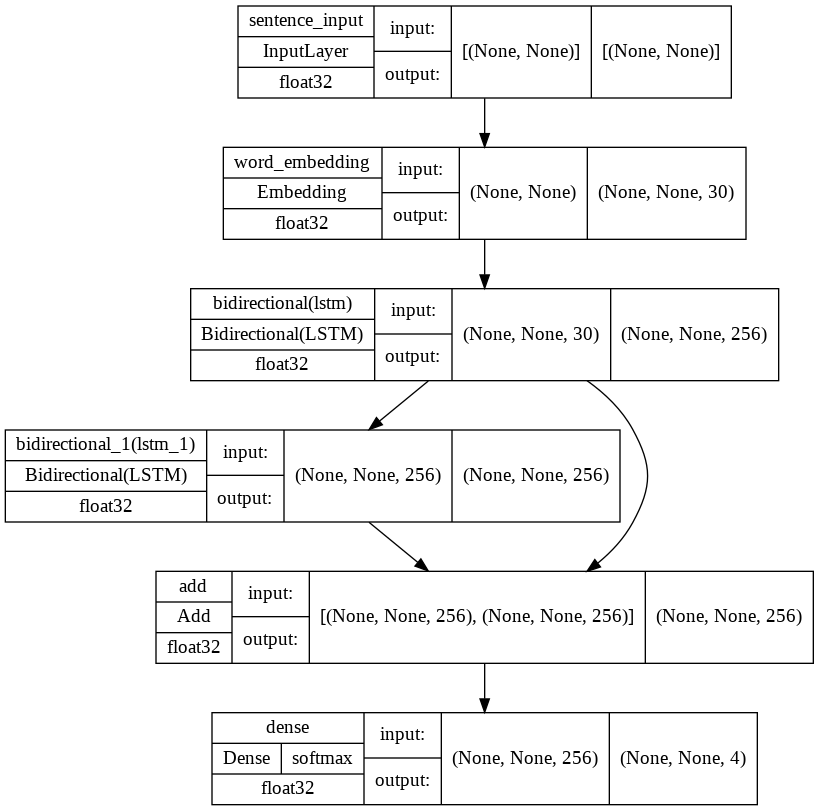

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_dtype=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
# fitting the model. We have saved the weights for easier access.
mc = ModelCheckpoint('/content/drive/MyDrive/AI-3/project/weights_hemanis_model_1_elmo.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
history = model.fit(new_sample,new_tags_padded, validation_split = 0.2, epochs=150,callbacks=[mc,es], batch_size=1024, verbose=2)

Epoch 1/150

Epoch 1: val_accuracy improved from -inf to 0.50936, saving model to /content/drive/MyDrive/AI-3/project/weights_hemanis_model_1_elmo.h5
8/8 - 26s - loss: 0.4234 - accuracy: 0.4659 - val_loss: 0.2776 - val_accuracy: 0.5094 - 26s/epoch - 3s/step
Epoch 2/150

Epoch 2: val_accuracy improved from 0.50936 to 0.68007, saving model to /content/drive/MyDrive/AI-3/project/weights_hemanis_model_1_elmo.h5
8/8 - 4s - loss: 0.2483 - accuracy: 0.5436 - val_loss: 0.1915 - val_accuracy: 0.6801 - 4s/epoch - 548ms/step
Epoch 3/150

Epoch 3: val_accuracy improved from 0.68007 to 0.70667, saving model to /content/drive/MyDrive/AI-3/project/weights_hemanis_model_1_elmo.h5
8/8 - 4s - loss: 0.2053 - accuracy: 0.6813 - val_loss: 0.1788 - val_accuracy: 0.7067 - 4s/epoch - 473ms/step
Epoch 4/150

Epoch 4: val_accuracy improved from 0.70667 to 0.71251, saving model to /content/drive/MyDrive/AI-3/project/weights_hemanis_model_1_elmo.h5
8/8 - 4s - loss: 0.1957 - accuracy: 0.7031 - val_loss: 0.1776 - v

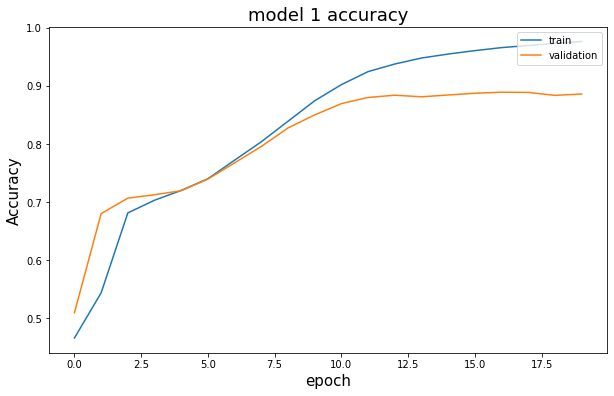

In [ ]:
# accuracy
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 1 accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# predicting on our train and test data
preds_train = model.predict(train_sentences_padded)
preds = model.predict(test_sentences_padded)

In [ ]:
# creating a function which returns arrays after finding argmax
def find_argmax(preds_1):
  preds_1_arr = []
  for record in preds_1:
    temp = []
    for words in record:
      temp.append(np.argmax(np.array(words)))
    preds_1_arr.append(temp)
  return preds_1_arr

In [ ]:
# structuring our predictions
preds_arr = find_argmax(preds)
preds_train_arr = find_argmax(preds_train)

In [ ]:
# Defining a function to convert an array to without padding
def convert_to_without_padding(preds_1_train_arr,train_Ns):
  prediction_without_padding_train_1 = []
  for pre,ori_si in zip(preds_1_train_arr,train_Ns):
    prediction_without_padding_train_1.append(np.array(pre[:ori_si]))
  return np.array(prediction_without_padding_train_1)

In [ ]:
# converting our predictions and true variables to without padding
# We are doing this to create a confusion matrix
prediction_without_padding_train = convert_to_without_padding(preds_train_arr,train_Ns)
prediction_without_padding_test = convert_to_without_padding(preds_arr,test_Ns)
true_without_padding_train = train_os + 1
true_without_padding_test = test_os + 1 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
# convert to 1D
def convert_to_1D(prediction_without_padding_test):
  prediction_without_padding_test_flatten = []
  for i in prediction_without_padding_test:
    prediction_without_padding_test_flatten += list(i)
  return np.array(prediction_without_padding_test_flatten)

In [ ]:
# converting to 1D
prediction_without_padding_train_flatten = convert_to_1D(prediction_without_padding_train)
prediction_without_padding_test_flatten = convert_to_1D(prediction_without_padding_test)
true_without_padding_train_flatten = convert_to_1D(true_without_padding_train)
true_without_padding_test_flatten = convert_to_1D(true_without_padding_test)

In [ ]:
prediction_without_padding_train_flatten.shape, prediction_without_padding_test_flatten.shape,true_without_padding_train_flatten.shape,true_without_padding_test_flatten.shape

((454395,), (111155,), (454395,), (111155,))

In [ ]:
def create_confusion_matrix(true_without_padding_train_flatten,prediction_without_padding_train_flatten,s):
  cf_matrix = confusion_matrix(true_without_padding_train_flatten,prediction_without_padding_train_flatten)
  ax = sns.heatmap(cf_matrix,annot=True, fmt='', cmap='Blues')
  ax.set_title(s);
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  ax.xaxis.set_ticklabels(['not o','o'])
  ax.yaxis.set_ticklabels(['not o','o'])
  plt.show()

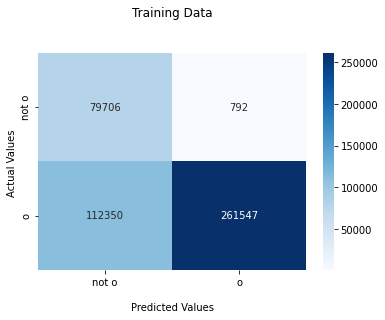

In [ ]:
create_confusion_matrix(true_without_padding_train_flatten,prediction_without_padding_train_flatten,'Training Data\n\n')

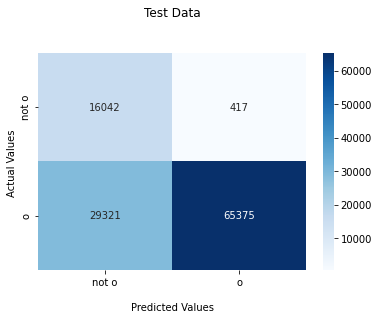

In [ ]:
create_confusion_matrix(true_without_padding_test_flatten,prediction_without_padding_test_flatten,'Test Data\n\n')

We see an improvement from our baseline model. In this case, we have less biased model.

In [ ]:
# saving our results so far
intermediate_prediction_training_data = []
for i_s in prediction_without_padding_train:
  temp = []
  for i in i_s:
    if i==2:
      temp.append(63)
    else:
      temp.append(np.nan)
  intermediate_prediction_training_data.append(temp)

In [ ]:
intermediate_prediction_testing_data = []
for i_s in prediction_without_padding_test:
  temp = []
  for i in i_s:
    if i==2:
      temp.append(63)
    else:
      temp.append(np.nan)
  intermediate_prediction_testing_data.append(temp)

### Model 2:</br>


This model will take the prediction from the first model and the tokens as well. By doing this essentially we want to flag the tokens which are not outside. this way we want to see if the model can predict better. This model will try to predict if the not 'o' tag is i or b. 

In [ ]:
# Here we are defining a function that will mask those values which has been classified into a specific category before
def dot_not_fun(prediction_without_padding_train,train_sentences):
  do_ot = []
  for pred,sentence in zip(prediction_without_padding_train,train_sentences):
    do_ot.append([np.dot(i,j) for i,j in zip(np.logical_not(pred).astype(int),sentence)])
  return np.array(do_ot)

In [ ]:
# masking 'o' tag values
dot_not = dot_not_fun((prediction_without_padding_train - 1),train_sentences)
dot_not_test = dot_not_fun((prediction_without_padding_test - 1),test_sentences)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
# defining the input for the next model
input_2 = np.array(dot_not)
input_2_padded = tf.keras.preprocessing.sequence.pad_sequences(input_2, padding='post')

input_2_test = np.array(dot_not_test)
input_2_test_padded = tf.keras.preprocessing.sequence.pad_sequences(input_2_test, padding='post')

In [ ]:
prediction_without_padding_train.shape, input_2.shape, input_2_padded.shape

((9779,), (9779,), (9779, 50))

In [ ]:
b_or_i_or_none = []
for i_s,b_s in zip(train_is,train_bs):
  temp = []
  for i,b in zip(i_s,b_s):
    if i==0 and b==0:
      temp.append(0)
    elif i==0 and b==1:
      temp.append(1)
    else:
      temp.append(2)
  b_or_i_or_none.append(np.array(temp))

In [ ]:
# Here we have defined b as 1, i as 2 and o as 0
# Defining the training output
b_or_i_or_none = []
for i_s,b_s in zip(train_is,train_bs):
  temp = []
  for i,b in zip(i_s,b_s):
    if i==0 and b==0:
      temp.append(0)
    elif i==0 and b==1:
      temp.append(1)
    else:
      temp.append(2)
  b_or_i_or_none.append(np.array(temp))

b_or_i_or_none = np.array(b_or_i_or_none)
output_2_padded = tf.keras.preprocessing.sequence.pad_sequences(b_or_i_or_none, padding='post')

# Defining the testing output
b_or_i_or_none_test = []
for i_s,b_s in zip(test_is,test_bs):
  temp = []
  for i,b in zip(i_s,b_s):
    if i==0 and b==0:
      temp.append(0)
    elif i==0 and b==1:
      temp.append(1)
    else:
      temp.append(2)
  b_or_i_or_none_test.append(np.array(temp))

b_or_i_or_none_test = np.array(b_or_i_or_none_test)
output_2_padded_test = tf.keras.preprocessing.sequence.pad_sequences(b_or_i_or_none_test, padding='post')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
test_is.shape, test_bs.shape

((2399,), (2399,))

In [ ]:
output_2_padded.shape, output_2_padded_test.shape

((9779, 50), (2399, 50))

In [ ]:
# tf.keras.backend.clear_session()
# hidden_size = 5
# sentence_input1 = tf.keras.Input(shape=(None,), name='dot_not_sentence_input')

# word_embedding_2 = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=4, 
#                     name='word_embedding_model_2', mask_zero=True)

# masked_embedding = word_embedding_2(sentence_input1)
# LSTM = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
# hf = LSTM(masked_embedding)
# LSTM_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
# hf_1 = LSTM_2(hf)
# dense = tf.keras.layers.Dense(3, activation='softmax')
# output = dense(hf_1)

# model_2 = tf.keras.Model(inputs=sentence_input1, outputs=output, name='simpleRNN')
# model_2.compile(loss='SparseCategoricalCrossentropy', optimizer='RMSProp', metrics = 'accuracy')

In [ ]:
tf.keras.backend.clear_session()

sentence_input1 = tf.keras.Input(shape=(None,), name='dot_not_sentence_input')

word_embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=30, 
                    name='word_embedding', mask_zero=True)
masked_embedding = word_embedding(sentence_input1)

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True))
hf_1 = lstm1(masked_embedding)

lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True))
hf = lstm2(hf_1)

hf_z = tf.keras.layers.add([hf, hf_1])

dense = tf.keras.layers.Dense(3, activation='softmax')
output = dense(hf_z)

model_2 = tf.keras.Model(inputs=sentence_input1, outputs=output, name='simpleRNN')
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = 'accuracy')

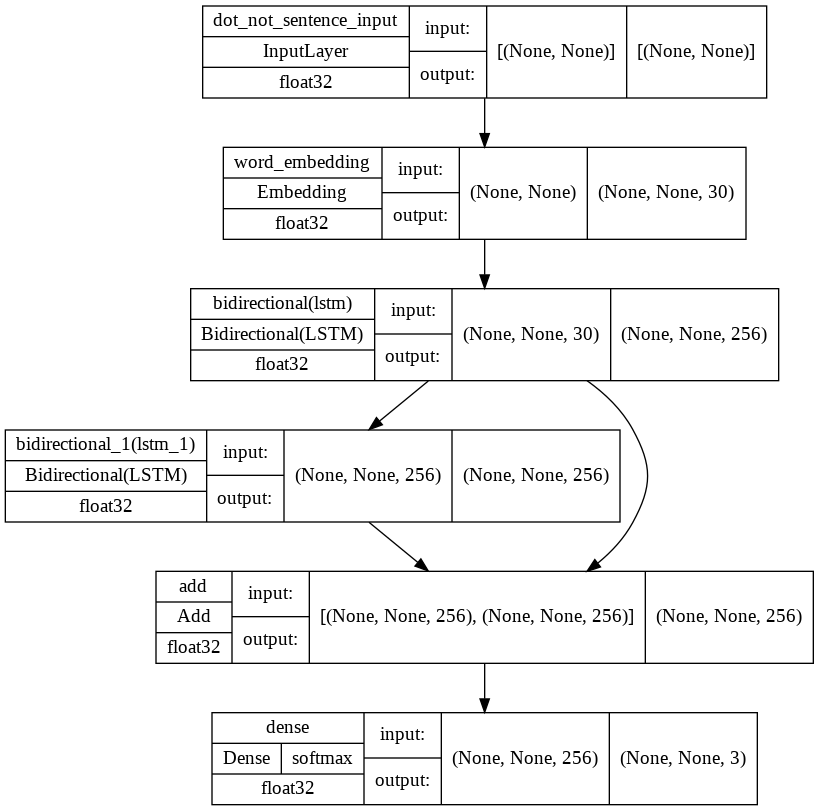

In [ ]:
tf.keras.utils.plot_model(model_2,show_shapes=True, show_dtype=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
# fitting the model. We have saved the weights for easier access.
mc = ModelCheckpoint('/content/drive/MyDrive/AI-3/project/weights_hemanis_model_2_elmo.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
history = model_2.fit(input_2_padded,output_2_padded, validation_split = 0.2, epochs=200,callbacks=[mc,es], batch_size=1024, verbose=2)

Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.62297, saving model to /content/drive/MyDrive/AI-3/project/weights_hemanis_model_2_elmo.h5
8/8 - 23s - loss: 0.4089 - accuracy: 0.5409 - val_loss: 0.3782 - val_accuracy: 0.6230 - 23s/epoch - 3s/step
Epoch 2/200

Epoch 2: val_accuracy did not improve from 0.62297
8/8 - 4s - loss: 0.3766 - accuracy: 0.5752 - val_loss: 0.3607 - val_accuracy: 0.6230 - 4s/epoch - 494ms/step
Epoch 3/200

Epoch 3: val_accuracy improved from 0.62297 to 0.67801, saving model to /content/drive/MyDrive/AI-3/project/weights_hemanis_model_2_elmo.h5
8/8 - 4s - loss: 0.3429 - accuracy: 0.5848 - val_loss: 0.3114 - val_accuracy: 0.6780 - 4s/epoch - 505ms/step
Epoch 4/200

Epoch 4: val_accuracy improved from 0.67801 to 0.69558, saving model to /content/drive/MyDrive/AI-3/project/weights_hemanis_model_2_elmo.h5
8/8 - 4s - loss: 0.3043 - accuracy: 0.6610 - val_loss: 0.2935 - val_accuracy: 0.6956 - 4s/epoch - 514ms/step
Epoch 5/200

Epoch 5: val_accuracy improved f

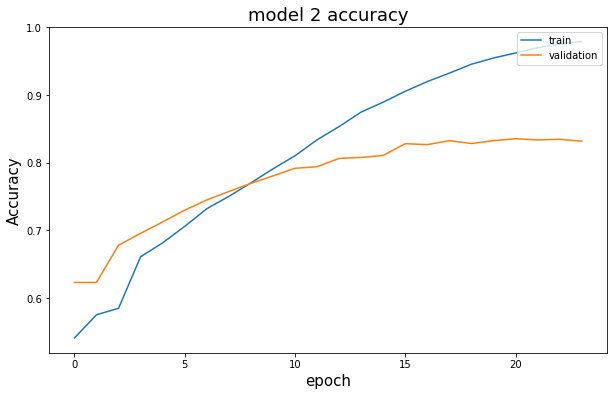

In [ ]:
# accuracy
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 2 accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# Predicting using our model
preds_train_1 = model_2.predict(train_sentences_padded)
preds_1 = model_2.predict(test_sentences_padded)

In [ ]:
# structuring our predictions
preds_1_arr = find_argmax(preds_1)
preds_1_train_arr = find_argmax(preds_train_1)

In [ ]:
# converting our predictions and true variables to without padding
# We are doing this to create a confusion matrix
prediction_without_padding_train_1 = convert_to_without_padding(preds_1_train_arr,train_Ns)
prediction_without_padding_test_1 = convert_to_without_padding(preds_1_arr,test_Ns)
true_without_padding_train_1 = b_or_i_or_none
true_without_padding_test_1 = b_or_i_or_none_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
# converting to 1D
prediction_without_padding_train_flatten_1 = convert_to_1D(prediction_without_padding_train_1)
prediction_without_padding_test_flatten_1 = convert_to_1D(prediction_without_padding_test_1)
true_without_padding_train_flatten_1 = convert_to_1D(true_without_padding_train_1)
true_without_padding_test_flatten_1 = convert_to_1D(true_without_padding_test_1)

In [ ]:
def create_confusion_matrix(true_without_padding_train_flatten,prediction_without_padding_train_flatten,s):
  cf_matrix = confusion_matrix(true_without_padding_train_flatten,prediction_without_padding_train_flatten)
  ax = sns.heatmap(cf_matrix,annot=True, fmt='', cmap='Blues')
  ax.set_title(s);
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  ax.xaxis.set_ticklabels(['padding','b','i'])
  ax.yaxis.set_ticklabels(['padding','b','i'])
  plt.show()

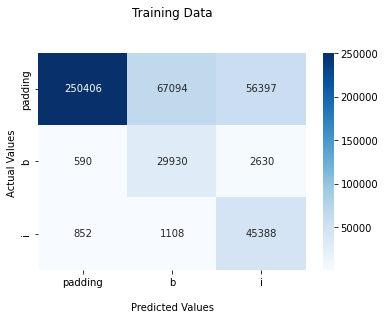

In [ ]:
create_confusion_matrix(true_without_padding_train_flatten_1,prediction_without_padding_train_flatten_1,'Training Data\n\n')

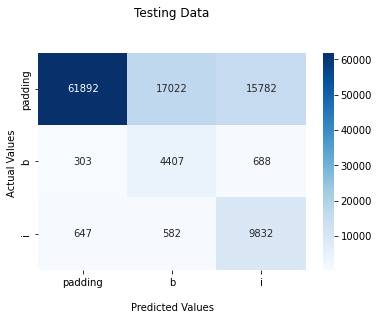

In [ ]:
create_confusion_matrix(true_without_padding_test_flatten_1,prediction_without_padding_test_flatten_1,'Testing Data\n\n')

In [ ]:
# Creating an intermediate prediction which has 63 for 'o', 'b' and 'i' for train data
now_train = []
for i_s,j_s in zip(prediction_without_padding_train_1,intermediate_prediction_training_data):
  temp = []
  for i,j in zip(i_s,j_s):
    if j is np.nan:
      if i==1:
        temp.append('b')
      elif i== 2:
        temp.append('i')
      else:
        temp.append(63)
        # print(i,j)
    else:
      temp.append(j)
  now_train.append(temp)

In [ ]:
# Creating an intermediate prediction which has 63 for 'o', 'b' and 'i'
now_test = []
for i_s,j_s in zip(prediction_without_padding_test_1,intermediate_prediction_testing_data):
  temp = []
  for i,j in zip(i_s,j_s):
    if j is np.nan:
      if i==1:
        temp.append('b')
      elif i== 2:
        temp.append('i')
      else:
        temp.append(63)
        # print(i,j)
    else:
      temp.append(j)
  now_test.append(temp)

### Model 3: now we will categorize b tags

In [ ]:
# creating a function which will give us the location of the b tags in our predictions
def flag_characters(now,c):
  is_only_train = []
  for i in now:
    temp = []
    for j in i:
      if j == c:
        temp.append(1)
      else:
        temp.append(0)
    is_only_train.append(temp)
  return is_only_train

In [ ]:
# Defining the locations at which bs are predicted.
ib_only_train = flag_characters(now_train,'b')
ib_only_test = flag_characters(now_test,'b')

In [ ]:
# Defining a function that masks tags already predicted
def mask_ip_op(is_only_train,train_sentences):
  dot_not_is = []
  for pred,sentence in zip(is_only_train,train_sentences):
    dot_not_is.append(np.array([np.dot(i,j) for i,j in zip(pred,sentence)]))
  return np.array(dot_not_is)

In [ ]:
# Defining inputs
input_3 = mask_ip_op(ib_only_train,train_sentences)
input_3_test = mask_ip_op(ib_only_test,test_sentences)

input_3_padded = tf.keras.preprocessing.sequence.pad_sequences(input_3, padding='post')
input_3_test_padded = tf.keras.preprocessing.sequence.pad_sequences(input_3_test, padding='post')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
# Defining outputs
output_3 = mask_ip_op(ib_only_train,train_tags)
output_3_test = mask_ip_op(ib_only_test,test_tags)

output_3_padded = tf.keras.preprocessing.sequence.pad_sequences(output_3, padding='post')
output_3_test_padded = tf.keras.preprocessing.sequence.pad_sequences(output_3_test, padding='post')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
input_3_padded.shape, input_3_test_padded.shape, output_3_padded.shape, output_3_test_padded.shape

((9779, 50), (2399, 50), (9779, 50), (2399, 50))

In [ ]:
# Here we have 30 categories a tag can be classified into
# 0 stands for  padding and 32 stands for others
tags[:31]

,index,0
0,B-Archive,1
1,B-CelestialObject,2
2,B-CelestialObjectRegion,3
3,B-CelestialRegion,4
4,B-Citation,5
5,B-Collaboration,6
6,B-ComputingFacility,7
7,B-Database,8
8,B-Dataset,9
9,B-EntityOfFutureInterest,10


In [ ]:
count_tag = {}
for j in output_3_padded:
  for i in j:
    if i in count_tag.keys():
      count_tag[i] += 1
    else:
      count_tag[i] = 1

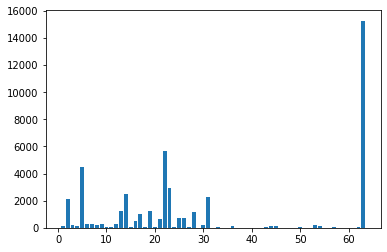

In [ ]:
# having a quick look at the distribution of the models. 
# We have not plotted the 0 (padding) tag to have a better look at the model
plt.bar(list(count_tag.keys())[1:],list(count_tag.values())[1:])
plt.show()

In [ ]:
# Here we have 30 categories a tag can be classified into
# 0 stands for  padding and 32 stands for others
output_3_padded_new = []
for i in output_3_padded:
  temp = []
  for j in i:
    if j>31:
      temp.append(32)
    else:
      temp.append(j)
  output_3_padded_new.append(temp)
output_3_padded_new = np.array(output_3_padded_new)

# Here we have 30 categories a tag can be classified into
# 0 stands for  padding and 32 stands for others
output_3_padded_new_test = []
for i in output_3_test_padded:
  temp = []
  for j in i:
    if j>31:
      temp.append(32)
    else:
      temp.append(j)
  output_3_padded_new_test.append(temp)
output_3_padded_new_test = np.array(output_3_padded_new_test)

In [ ]:
# defining masked output
output_3_padded_new.shape, output_3_padded_new_test.shape

((9779, 50), (2399, 50))

In [ ]:
# tf.keras.backend.clear_session()
# hidden_size = 100
# sentence_input1 = tf.keras.Input(shape=(None,), name='dot_not_sentence_input')

# word_embedding_2 = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=hidden_size, 
#                     name='word_embedding_model_2', mask_zero=True)

# masked_embedding = word_embedding_2(sentence_input1)
# LSTM = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
# hf = LSTM(masked_embedding)
# LSTM_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
# hf_1 = LSTM_2(hf)
# dense = tf.keras.layers.Dense(33, activation='softmax')
# output = dense(hf_1)

# model_3 = tf.keras.Model(inputs=sentence_input1, outputs=output, name='simpleRNN')
# model_3.compile(loss='SparseCategoricalCrossentropy', optimizer='RMSProp', metrics = 'accuracy')

In [ ]:
tf.keras.backend.clear_session()
sentence_input1 = tf.keras.Input(shape=(None,), name='sentence_input')

word_embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=30, 
                    name='word_embedding', mask_zero=True)
masked_embedding = word_embedding(sentence_input1)

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True))
hf_1 = lstm1(masked_embedding)

lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True))
hf = lstm2(hf_1)

hf_z = tf.keras.layers.add([hf, hf_1])

dense = tf.keras.layers.Dense(33, activation='softmax')
output = dense(hf_z)

model_3 = tf.keras.Model(inputs=sentence_input1, outputs=output, name='simpleRNN')
model_3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = 'accuracy')

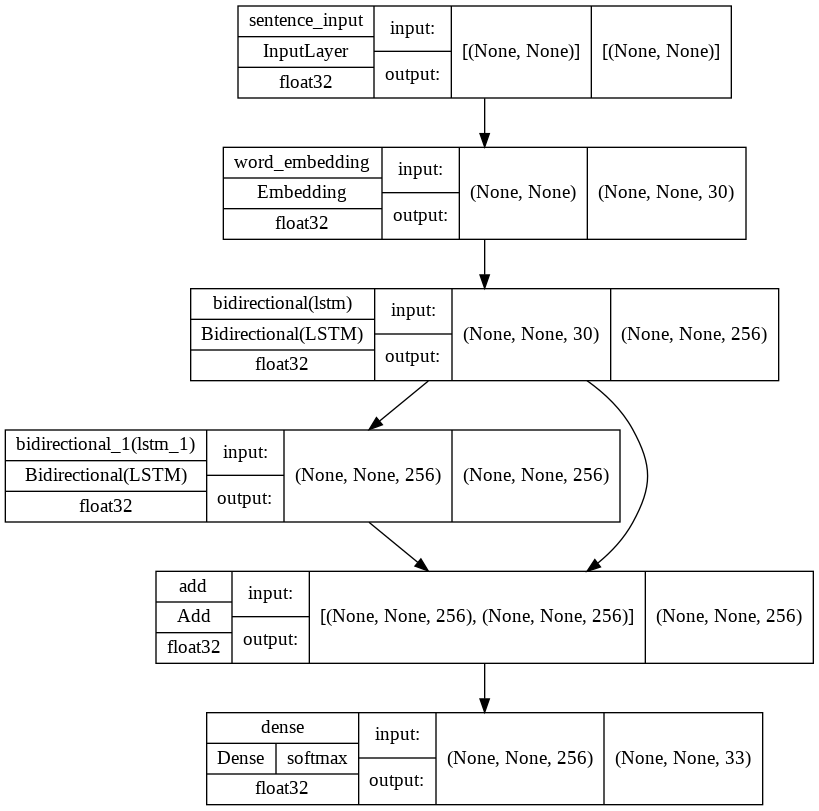

In [ ]:
tf.keras.utils.plot_model(model_3,show_shapes=True, show_dtype=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
# fitting the model. We have saved the weights for easier access.
mc = ModelCheckpoint('/content/drive/MyDrive/AI-3/project/weights_hemanis_model_3_elmo.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
history = model_3.fit(input_3_padded,output_3_padded_new, validation_split = 0.2, epochs=200,callbacks=[mc,es], batch_size=1024, verbose=2)

Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.51359, saving model to /content/drive/MyDrive/AI-3/project/weights_hemanis_model_3_elmo.h5
8/8 - 23s - loss: 0.3186 - accuracy: 0.2679 - val_loss: 0.3449 - val_accuracy: 0.5136 - 23s/epoch - 3s/step
Epoch 2/200

Epoch 2: val_accuracy improved from 0.51359 to 0.51399, saving model to /content/drive/MyDrive/AI-3/project/weights_hemanis_model_3_elmo.h5
8/8 - 4s - loss: 0.2962 - accuracy: 0.3218 - val_loss: 0.2803 - val_accuracy: 0.5140 - 4s/epoch - 505ms/step
Epoch 3/200

Epoch 3: val_accuracy did not improve from 0.51399
8/8 - 6s - loss: 0.2634 - accuracy: 0.3620 - val_loss: 0.2576 - val_accuracy: 0.4865 - 6s/epoch - 728ms/step
Epoch 4/200

Epoch 4: val_accuracy improved from 0.51399 to 0.51845, saving model to /content/drive/MyDrive/AI-3/project/weights_hemanis_model_3_elmo.h5
8/8 - 9s - loss: 0.2434 - accuracy: 0.3613 - val_loss: 0.2354 - val_accuracy: 0.5184 - 9s/epoch - 1s/step
Epoch 5/200

Epoch 5: val_accuracy did not impro

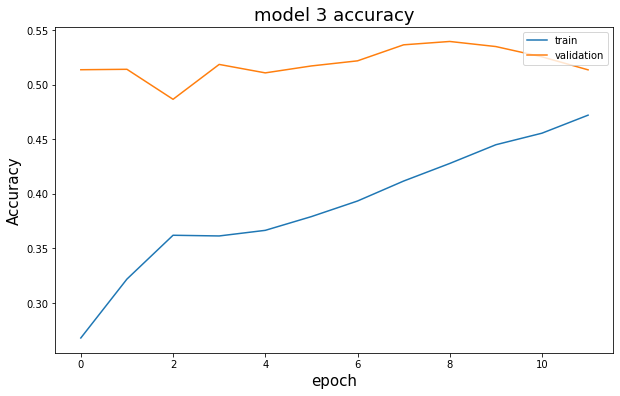

In [ ]:
# accuracy
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 3 accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# Predicting using our model
preds_train_3= model_3.predict(train_sentences_padded)
preds_3 = model_3.predict(test_sentences_padded)

In [ ]:
# structuring our predictions
preds_3_arr = find_argmax(preds_3)
preds_3_train_arr = find_argmax(preds_train_3)

In [ ]:
# converting our predictions and true variables to without padding
# We are doing this to create a confusion matrix
prediction_without_padding_train_3 = convert_to_without_padding(preds_3_train_arr,train_Ns)
prediction_without_padding_test_3 = convert_to_without_padding(preds_3_arr,test_Ns)
true_without_padding_train_3 = output_3_padded_new
true_without_padding_test_3 = output_3_padded_new_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
# converting to 1D
prediction_without_padding_train_flatten_3 = convert_to_1D(prediction_without_padding_train_3)
prediction_without_padding_test_flatten_3 = convert_to_1D(prediction_without_padding_test_3)
true_without_padding_train_flatten_3 = convert_to_1D(true_without_padding_train_3)
true_without_padding_test_flatten_3 = convert_to_1D(true_without_padding_test_3)

In [ ]:
# Creating an intermediate prediction which has 63 for 'o', 'b' and 'i' for train data
semi_final_train = []
for i_s,j_s in zip(prediction_without_padding_train_3,now_train):
  temp = []
  for i,j in zip(i_s,j_s):
    # print(i,j)
    if j is 'b':
      if i != 32:
        temp.append(int(i))
      else:
        temp.append(63)
    else:
      temp.append(j)
  semi_final_train.append(temp)

In [ ]:
# Creating an intermediate prediction which has 63 for 'o', 'b' and 'i' for train data
semi_final_test = []
for i_s,j_s in zip(prediction_without_padding_test_3,now_test):
  temp = []
  for i,j in zip(i_s,j_s):
    if j is 'b':
      if i != 32:
        temp.append(int(i))
      else:
        temp.append(63)
    else:
      temp.append(j)
  semi_final_test.append(temp)

### Model 4: Predicting i</br>


In [ ]:
# Defining the locations at which is are predicted.
is_only_train = flag_characters(now_train,'i')
is_only_test = flag_characters(now_test,'i')

In [ ]:
# Defining inputs
input_4 = mask_ip_op(is_only_train,train_sentences)
input_4_test = mask_ip_op(is_only_test,test_sentences)

input_4_padded = tf.keras.preprocessing.sequence.pad_sequences(input_4, padding='post')
input_4_test_padded = tf.keras.preprocessing.sequence.pad_sequences(input_4_test, padding='post')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
# Defining outputs
output_4 = mask_ip_op(is_only_train,train_tags)
output_4_test = mask_ip_op(is_only_test,test_tags)

output_4_padded = tf.keras.preprocessing.sequence.pad_sequences(output_4, padding='post')
output_4_test_padded = tf.keras.preprocessing.sequence.pad_sequences(output_4_test, padding='post')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
input_4_padded.shape, input_4_test_padded.shape, output_4_padded.shape, output_4_test_padded.shape

((9779, 50), (2399, 50), (9779, 50), (2399, 50))

In [ ]:
tags[31:62]

,index,0
31,I-Archive,32
32,I-CelestialObject,33
33,I-CelestialObjectRegion,34
34,I-CelestialRegion,35
35,I-Citation,36
36,I-Collaboration,37
37,I-ComputingFacility,38
38,I-Database,39
39,I-Dataset,40
40,I-EntityOfFutureInterest,41


In [ ]:
count_tag_i = {}
for j in output_4_padded:
  for i in j:
    if i in count_tag_i.keys():
      count_tag_i[i] += 1
    else:
      count_tag_i[i] = 1

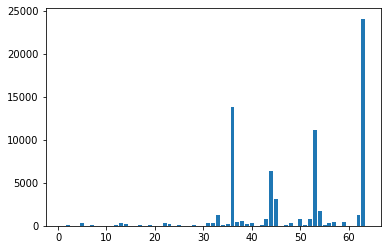

In [ ]:
plt.bar(list(count_tag_i.keys())[1:],list(count_tag_i.values())[1:])
plt.show()

In [ ]:
# Here we have 30 categories a tag can be classified into
# 0 stands for  padding and 32 stands for others
output_4_padded_new = []
for i in output_4_padded:
  temp = []
  for j in i:
    if j == 0:
      temp.append(0)
    elif j<32 or j>62:
      temp.append(32)
    else:
      temp.append(j-31)
  output_4_padded_new.append(temp)
output_4_padded_new = np.array(output_4_padded_new)  

output_4_padded_new_test = []
for i in output_4_test_padded:
  temp = []
  for j in i:
    if j == 0:
      temp.append(32)
    elif j<32 or j>62:
      temp.append(0)
    else:
      temp.append(j-31)
  output_4_padded_new_test.append(temp)
output_4_padded_new_test = np.array(output_4_padded_new_test) 

In [ ]:
output_4_padded_new.shape, output_4_padded_new_test.shape

((9779, 50), (2399, 50))

In [ ]:
tf.keras.backend.clear_session()
sentence_input1 = tf.keras.Input(shape=(None,), name='sentence_input')

word_embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=30, 
                    name='word_embedding', mask_zero=True)
masked_embedding = word_embedding(sentence_input1)

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True))
hf_1 = lstm1(masked_embedding)

lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True))
hf = lstm2(hf_1)

hf_z = tf.keras.layers.add([hf, hf_1])

dense = tf.keras.layers.Dense(33, activation='softmax')
output = dense(hf_z)

model_4 = tf.keras.Model(inputs=sentence_input1, outputs=output, name='simpleRNN')
model_4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = 'accuracy')

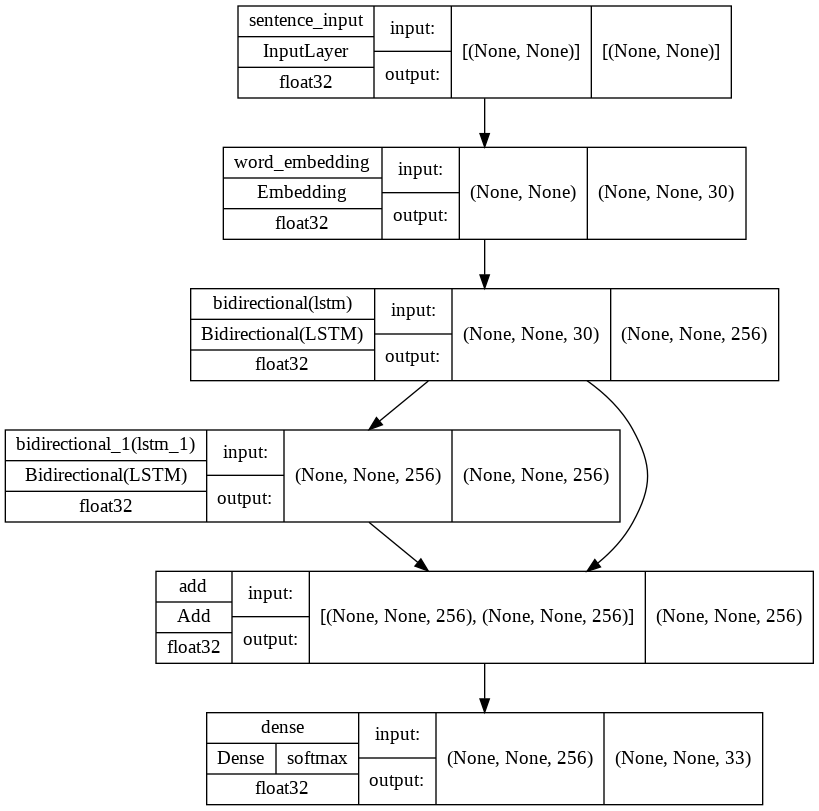

In [ ]:
tf.keras.utils.plot_model(model_4,show_shapes=True, show_dtype=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
# fitting the model. We have saved the weights for easier access.
mc = ModelCheckpoint('/content/drive/MyDrive/AI-3/project/weights_hemanis_model_4_elmo.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
history = model_4.fit(input_4_padded,output_4_padded_new, validation_split = 0.2, epochs=200,callbacks=[mc,es], batch_size=1024, verbose=2)

Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.51677, saving model to /content/drive/MyDrive/AI-3/project/weights_hemanis_model_4_elmo.h5
8/8 - 24s - loss: 0.4951 - accuracy: 0.3285 - val_loss: 0.5000 - val_accuracy: 0.5168 - 24s/epoch - 3s/step
Epoch 2/200

Epoch 2: val_accuracy did not improve from 0.51677
8/8 - 4s - loss: 0.4086 - accuracy: 0.3626 - val_loss: 0.3550 - val_accuracy: 0.4012 - 4s/epoch - 486ms/step
Epoch 3/200

Epoch 3: val_accuracy did not improve from 0.51677
8/8 - 4s - loss: 0.3454 - accuracy: 0.3943 - val_loss: 0.3164 - val_accuracy: 0.4934 - 4s/epoch - 492ms/step
Epoch 4/200

Epoch 4: val_accuracy improved from 0.51677 to 0.51748, saving model to /content/drive/MyDrive/AI-3/project/weights_hemanis_model_4_elmo.h5
8/8 - 4s - loss: 0.3109 - accuracy: 0.4059 - val_loss: 0.2924 - val_accuracy: 0.5175 - 4s/epoch - 504ms/step
Epoch 5/200

Epoch 5: val_accuracy improved from 0.51748 to 0.54297, saving model to /content/drive/MyDrive/AI-3/project/weights_heman

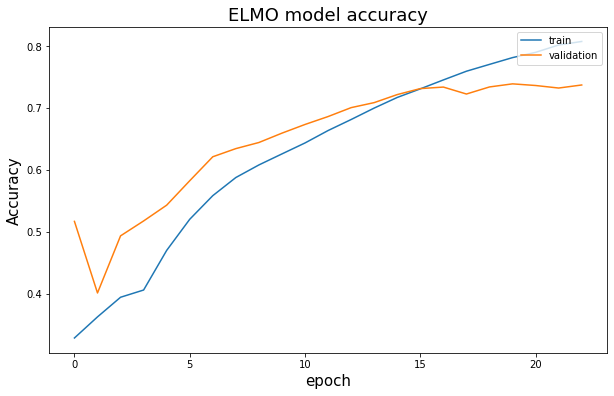

In [ ]:
# accuracy
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ELMO model accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# Predicting using our model
preds_train_4= model_4.predict(train_sentences_padded)
preds_4 = model_4.predict(test_sentences_padded)

In [ ]:
# structuring our predictions
preds_4_arr = find_argmax(preds_4)
preds_4_train_arr = find_argmax(preds_train_4)

In [ ]:
# converting our predictions and true variables to without padding
# We are doing this to create a confusion matrix
prediction_without_padding_train_4 = convert_to_without_padding(preds_4_train_arr,train_Ns)
prediction_without_padding_test_4 = convert_to_without_padding(preds_4_arr,test_Ns)
true_without_padding_train_4 = output_4_padded_new
true_without_padding_test_4 = output_4_padded_new_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
# converting to 1D
prediction_without_padding_train_flatten_4 = convert_to_1D(prediction_without_padding_train_4)
prediction_without_padding_test_flatten_4 = convert_to_1D(prediction_without_padding_test_4)
true_without_padding_train_flatten_4 = convert_to_1D(true_without_padding_train_4)
true_without_padding_test_flatten_4 = convert_to_1D(true_without_padding_test_4)

### Final Results

In [ ]:
# Creating an intermediate prediction which has 63 for 'o', 'b' and 'i' for train data
final_train = []
for i_s,j_s in zip(prediction_without_padding_train_4,semi_final_train):
  temp = []
  for i,j in zip(i_s,j_s):
    if j is 'i':
      if i!=32 or i!=0:
        temp.append(i+31)
      else:
        temp.append(63)
    else:
      temp.append(j)
  final_train.append(np.array(temp))

In [ ]:
# Creating an intermediate prediction which has 63 for 'o', 'b' and 'i' for train data
final_test = []
for i_s,j_s in zip(prediction_without_padding_test_4,semi_final_test):
  temp = []
  for i,j in zip(i_s,j_s):
    if j is 'i':
      if i!=32 or i!=0:
        temp.append(i+31)
      else:
        temp.append(63)
    else:
      temp.append(j)
  final_test.append(np.array(temp))

In [ ]:
# Having a look at the distribution in prediction
unique, counts = np.unique(convert_to_1D(final_test), return_counts=True)

from prettytable import PrettyTable
columns=['Predictions','Tag', 'Count']
mytable = PrettyTable()
mytable.add_column(columns[0], unique)
mytable.add_column(columns[1], tags.iloc[unique-1]['index'].values)
mytable.add_column(columns[2], counts)

print(mytable)

+-------------+---------------------+-------+
| Predictions |         Tag         | Count |
+-------------+---------------------+-------+
|      2      |  B-CelestialObject  |   17  |
|      5      |      B-Citation     |  155  |
|      14     |       B-Grant       |  270  |
|      17     |      B-Location     |   1   |
|      22     |    B-Organization   |  335  |
|      23     |       B-Person      |  2874 |
|      31     |     B-Wavelength    |  4522 |
|      33     |  I-CelestialObject  |   4   |
|      35     |  I-CelestialRegion  |  322  |
|      36     |      I-Citation     |  3748 |
|      37     |   I-Collaboration   |  130  |
|      38     | I-ComputingFacility |   42  |
|      40     |      I-Dataset      |   4   |
|      43     |     I-Fellowship    |  207  |
|      44     |      I-Formula      |  368  |
|      45     |       I-Grant       |  5185 |
|      48     |      I-Location     |   2   |
|      50     |       I-Model       |   2   |
|      52     |    I-Observatory  

In [ ]:
# Having a look at the distribution of prediction in test data
unique, counts = np.unique(convert_to_1D(final_train), return_counts=True)

from prettytable import PrettyTable
columns=['Predictions','Tag', 'Count']
mytable = PrettyTable()
mytable.add_column(columns[0], unique)
mytable.add_column(columns[1], tags.iloc[unique-1]['index'].values)
mytable.add_column(columns[2], counts)

print(mytable)

+-------------+---------------------+--------+
| Predictions |         Tag         | Count  |
+-------------+---------------------+--------+
|      2      |  B-CelestialObject  |  176   |
|      5      |      B-Citation     |  1168  |
|      14     |       B-Grant       |  1281  |
|      17     |      B-Location     |   1    |
|      22     |    B-Organization   |  1875  |
|      23     |       B-Person      | 16505  |
|      25     |      B-Software     |   3    |
|      26     |       B-Survey      |   5    |
|      28     |     B-Telescope     |   2    |
|      31     |     B-Wavelength    | 20319  |
|      32     |      I-Archive      |   2    |
|      33     |  I-CelestialObject  |   54   |
|      35     |  I-CelestialRegion  |  1315  |
|      36     |      I-Citation     | 12471  |
|      37     |   I-Collaboration   |  644   |
|      38     | I-ComputingFacility |  414   |
|      40     |      I-Dataset      |   24   |
|      43     |     I-Fellowship    |  996   |
|      44    

In [ ]:
# having a look at the classification report of test tags
print(classification_report(convert_to_1D(test_tags),convert_to_1D(np.array(final_test))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        40
           2       0.06      0.00      0.00       404
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00        23
           5       0.35      0.09      0.14       627
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00        54
           8       0.00      0.00      0.00        41
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        53
          13       0.00      0.00      0.00       402
          14       0.10      0.09      0.09       303
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        89
          17       0.00      0.00      0.00       248
          18       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# having a look at the classification report of test data
print(classification_report(convert_to_1D(train_tags),convert_to_1D(np.array(final_train))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


              precision    recall  f1-score   support

           1       1.00      0.00      0.00       151
           2       0.22      0.02      0.03      2370
           3       1.00      0.00      0.00       228
           4       1.00      0.00      0.00       129
           5       0.39      0.09      0.15      4847
           6       1.00      0.00      0.00       263
           7       1.00      0.00      0.00       321
           8       1.00      0.00      0.00       212
           9       1.00      0.00      0.00       293
          10       1.00      0.00      0.00        60
          11       1.00      0.00      0.00        39
          12       1.00      0.00      0.00       335
          13       1.00      0.00      0.00      1667
          14       0.17      0.08      0.10      2834
          15       1.00      0.00      0.00       104
          16       1.00      0.00      0.00       574
          17       0.00      0.00      0.00      1118
          18       1.00    

In [ ]:
# Printing the final train accuracy 
tru = 0
fal = 0
for i_s,j_s in zip(np.array(final_train),train_tags):
  for i,j in zip(i_s,j_s):
    if i==j:
      tru += 1
    else:
      fal +=1
train_accuracy = tru/(tru+fal)
print("The final training accuracy is : ", train_accuracy)

The final training accuracy is :  0.8324673466917549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [ ]:
tru = 0
fal = 0
for i_s,j_s in zip(np.array(final_test),test_tags):
  for i,j in zip(i_s,j_s):
    if i==j:
      tru += 1
    else:
      fal +=1
test_accuracy = tru/(tru+fal)
print("The final testing accuracy is : ", test_accuracy)

The final testing accuracy is :  0.8387836804462238


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
